In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os


Data Loading

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving cats_and_dogs_filtered.zip to cats_and_dogs_filtered.zip


In [ ]:
import zipfile
import os

zip_path = "cats_and_dogs_filtered.zip"

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

# Check extracted folders
print("Extracted:", os.listdir())

# Set correct paths
base_dir = 'cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

print("Train exists?", os.path.isdir(train_dir))
print("Validation exists?", os.path.isdir(validation_dir))


Extracted: ['.config', 'cats_and_dogs_filtered', 'cats_and_dogs_filtered.zip', 'sample_data']
Train exists? True
Validation exists? True


Data *preprocessing*

In [ ]:
import tensorflow as tf

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


show first nine images and labels from dataset

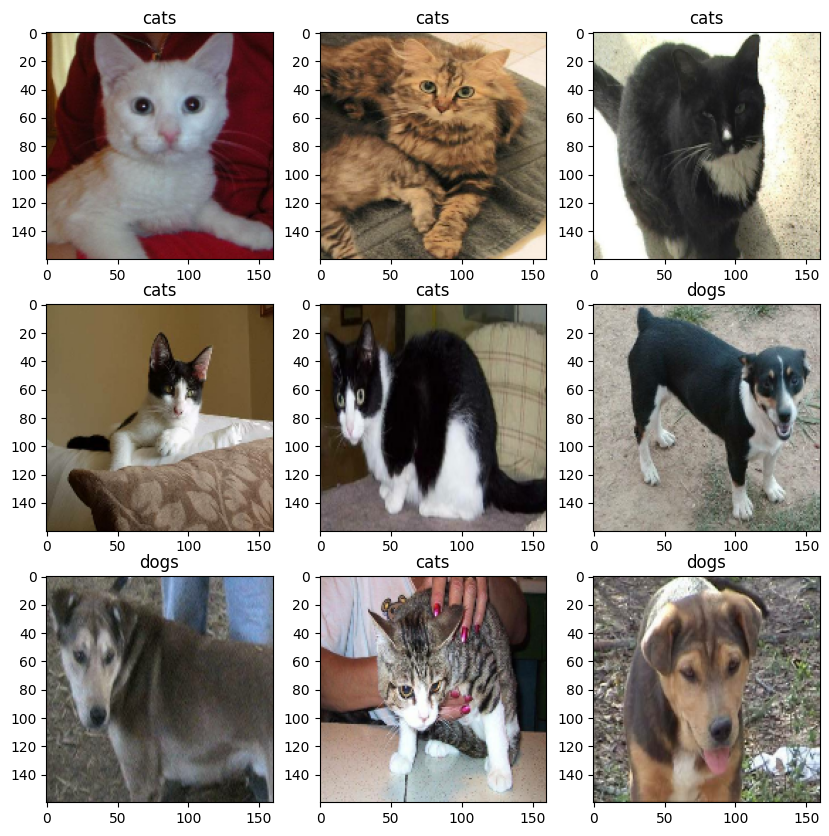

In [ ]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])

Test set

In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 26
Number of test batches: 6


Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Applying these layers to same images to see the result

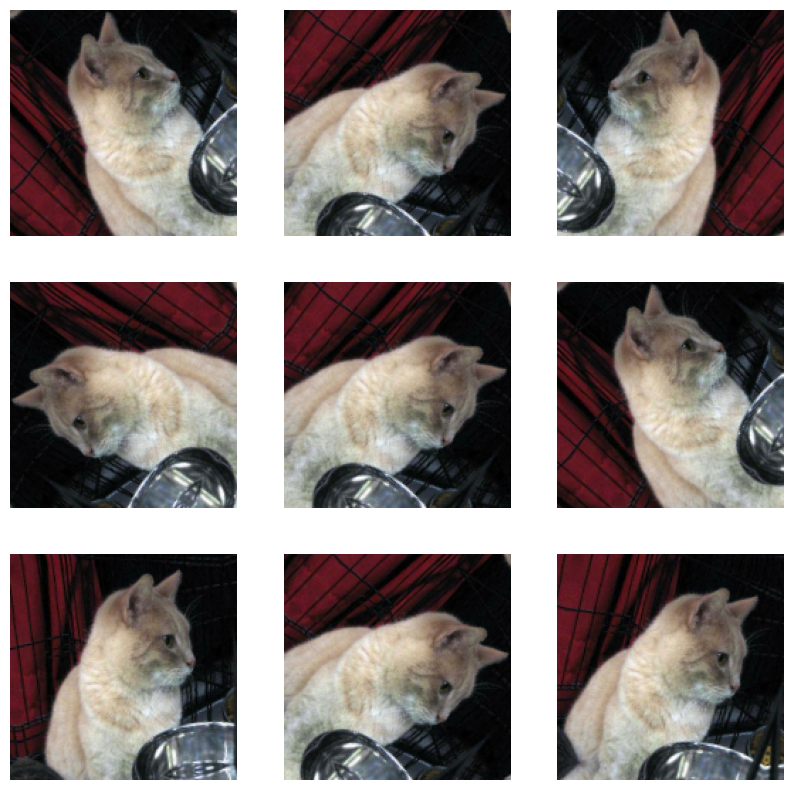

In [ ]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Rescale pixel value

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Creating a base model from MobileNet V2 model using ImageNet Dataset

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Batch of images

In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


Freeze Convolutional base

In [ ]:
base_model.trainable = False

Base model architecture

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

Classificiation head

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
len(model.trainable_variables)

2

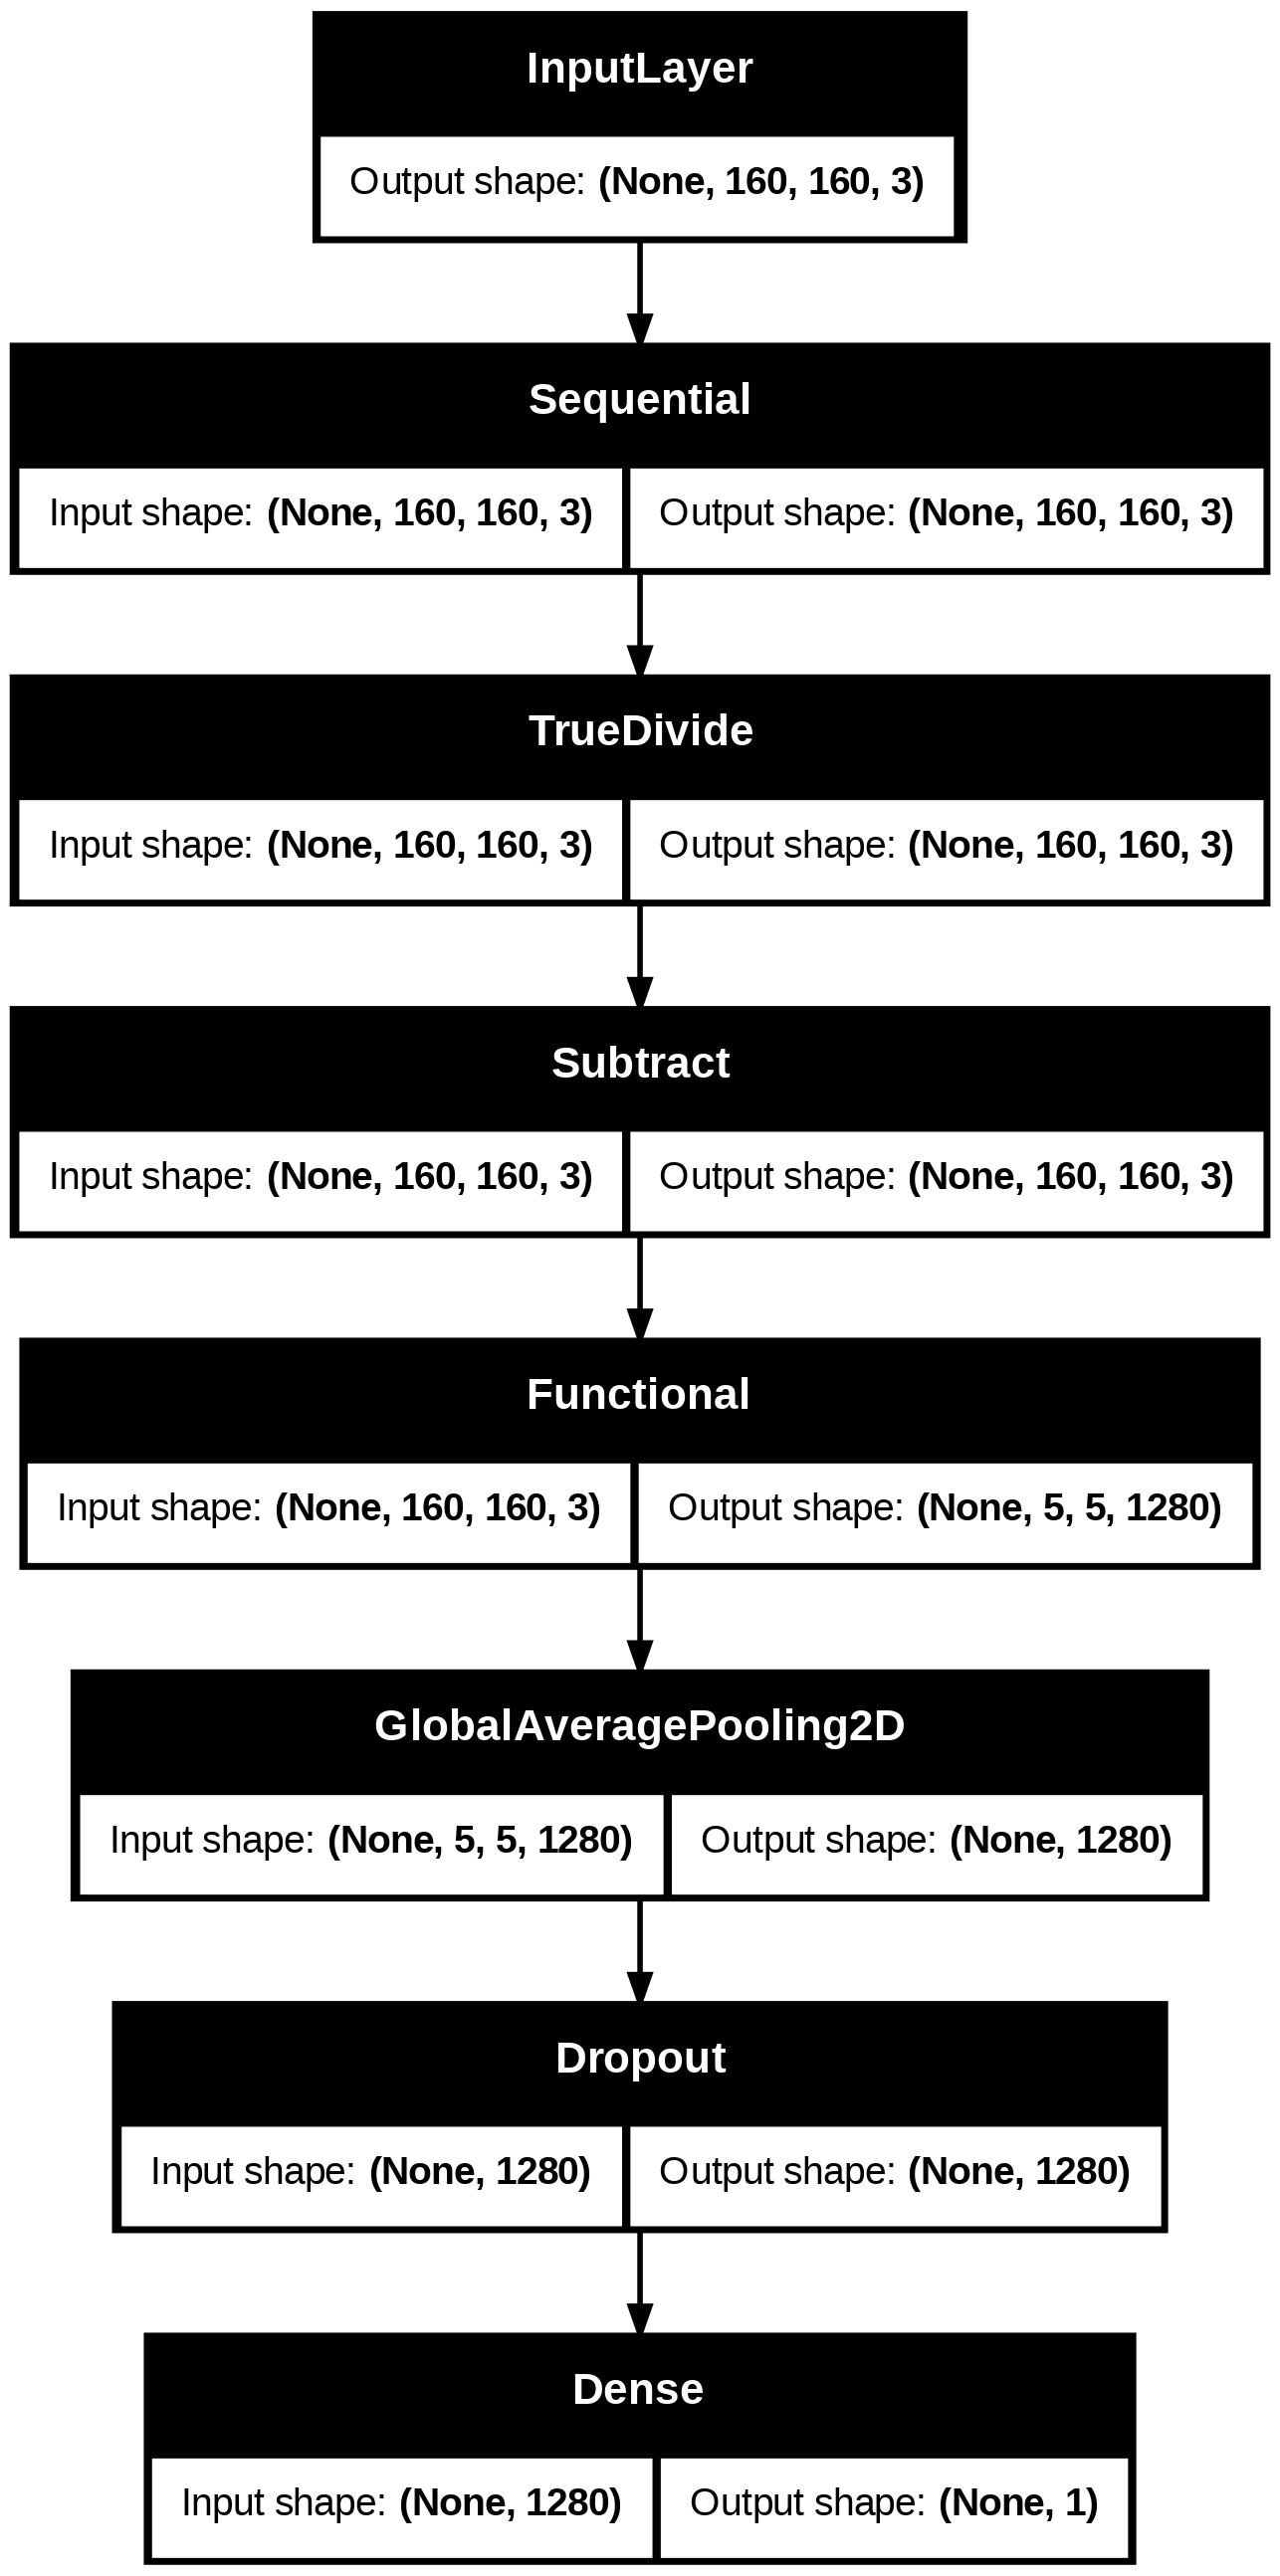

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

Compile the model

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

Train the model

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 597ms/step - accuracy: 0.4917 - loss: 0.7813


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.63
initial accuracy: 0.65


In [ ]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 66s 948ms/step - accuracy: 0.5529 - loss: 0.7434 - val_accuracy: 0.7426 - val_loss: 0.5380
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 61s 955ms/step - accuracy: 0.6975 - loss: 0.5774 - val_accuracy: 0.8589 - val_loss: 0.4058
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 946ms/step - accuracy: 0.8152 - loss: 0.4356 - val_accuracy: 0.8985 - val_loss: 0.3256
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 83s 965ms/step - accuracy: 0.8395 - loss: 0.3945 - val_accuracy: 0.9208 - val_loss: 0.2677
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.8626 - loss: 0.3254 - val_accuracy: 0.9369 - val_loss: 0.2232
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 972ms/step - accuracy: 0.8875 - loss: 0.3018 - val_accuracy: 0.9480 - val_loss: 0.1962
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 962ms/step - accuracy: 0.8932 - loss: 0.2775 - val_accuracy: 0.9505 - val_loss: 0.1806
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9013 - loss: 0.2599 - val_accuracy: 

Learning Curves

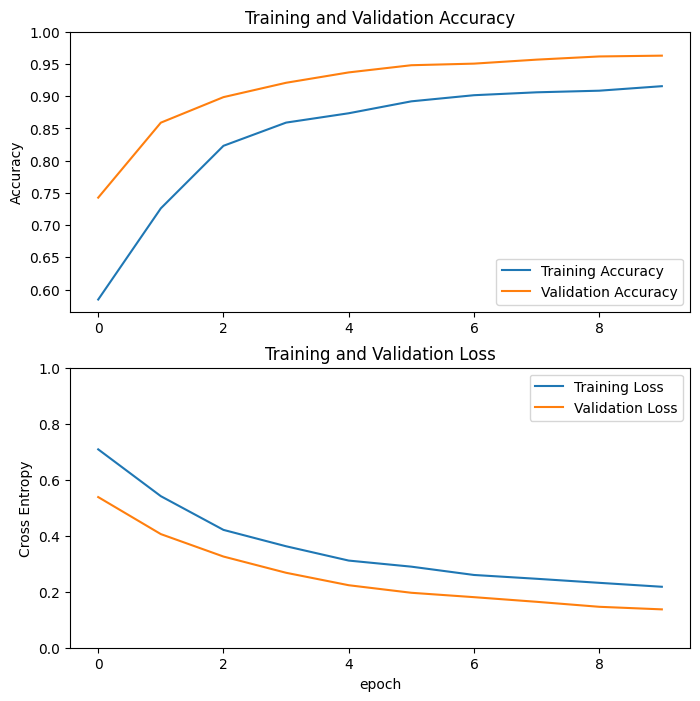

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Fine Tuning

In [ ]:
base_model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))


fine_tune_at = 100


for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


Compile The Model

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [ ]:
len(model.trainable_variables)

158

Continue Training Model

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data = val_ds)

Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 253s 4s/step - accuracy: 0.8105 - loss: 0.3989 - val_accuracy: 0.9678 - val_loss: 0.0899
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 258s 4s/step - accuracy: 0.9030 - loss: 0.2632 - val_accuracy: 0.9765 - val_loss: 0.0743
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 257s 3s/step - accuracy: 0.9052 - loss: 0.2245 - val_accuracy: 0.9814 - val_loss: 0.0599
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 256s 3s/step - accuracy: 0.9233 - loss: 0.2062 - val_accuracy: 0.9802 - val_loss: 0.0560
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.9399 - loss: 0.1506 - val_accuracy: 0.9814 - val_loss: 0.0479
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.9383 - loss: 0.1579 - val_accuracy: 0.9814 - val_loss: 0.0485
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step - accuracy: 0.9395 - loss: 0.1506 - val_accuracy: 0.9802 - val_loss: 0.0484
Epoch 18/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step - accuracy: 0.9459 - loss: 0.1379 - val_accuracy: 0.

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

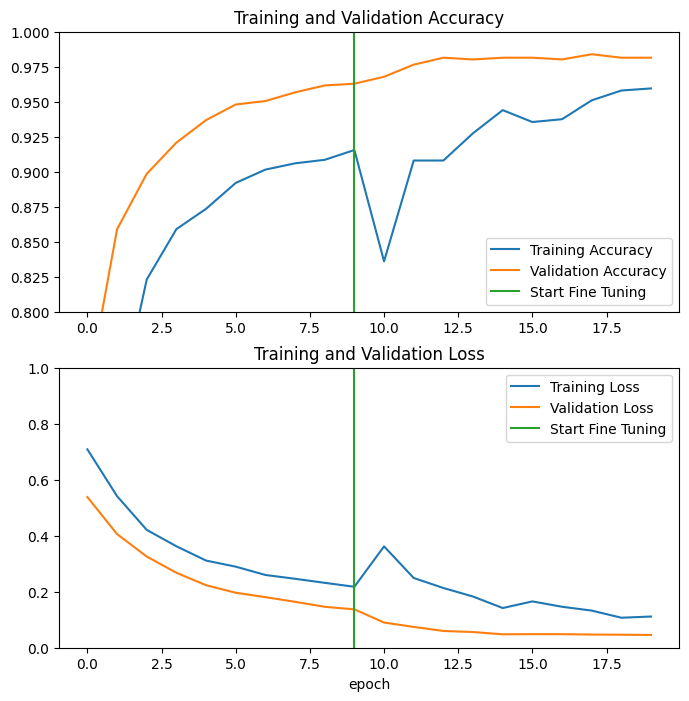

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Evaluation and Prediction

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 640ms/step - accuracy: 0.9965 - loss: 0.0246
Test accuracy : 0.9947916865348816


Predictions:
 [1 0 0 1 1 1 1 1 1 0 0 0 1 1 0 1 1 1 1 0 0 0 1 0 1 1 1 1 0 0 1 1]
Labels:
 [1 0 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 0 0 1 0 1 1 1 1 0 0 1 1]


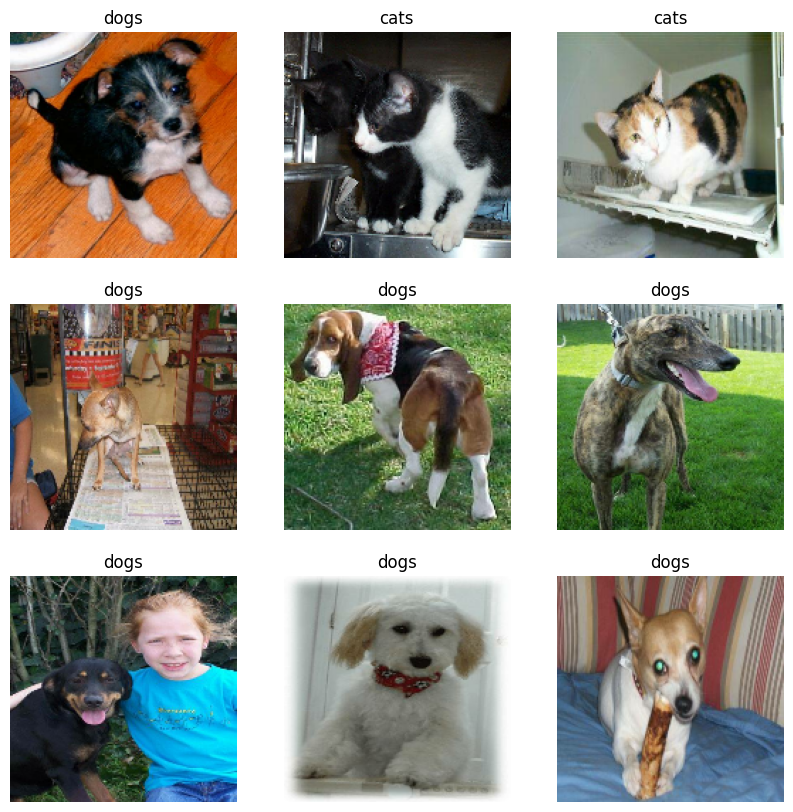

In [ ]:

image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

For ResNet dataset

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

base_model = ResNet50(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
base_model.trainable = False


Data Augmentation

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

compilation

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

training model

In [ ]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 266s 4s/step - accuracy: 0.5593 - loss: 0.8235 - val_accuracy: 0.7871 - val_loss: 0.4414
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 271s 4s/step - accuracy: 0.7653 - loss: 0.4990 - val_accuracy: 0.9047 - val_loss: 0.2726
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 309s 4s/step - accuracy: 0.8392 - loss: 0.3900 - val_accuracy: 0.9431 - val_loss: 0.1954
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 251s 4s/step - accuracy: 0.8934 - loss: 0.2813 - val_accuracy: 0.9505 - val_loss: 0.1529
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 263s 4s/step - accuracy: 0.9104 - loss: 0.2471 - val_accuracy: 0.9604 - val_loss: 0.1316
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 273s 4s/step - accuracy: 0.9092 - loss: 0.2311 - val_accuracy: 0.9653 - val_loss: 0.1161
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 321s 4s/step - accuracy: 0.9170 - loss: 0.2028 - val_accuracy: 0.9678 - val_loss: 0.1059
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 253s 4s/step - accuracy: 0.9275 - loss: 0.2061 - val_accuracy: 0.9703 - v

plotting learning curves

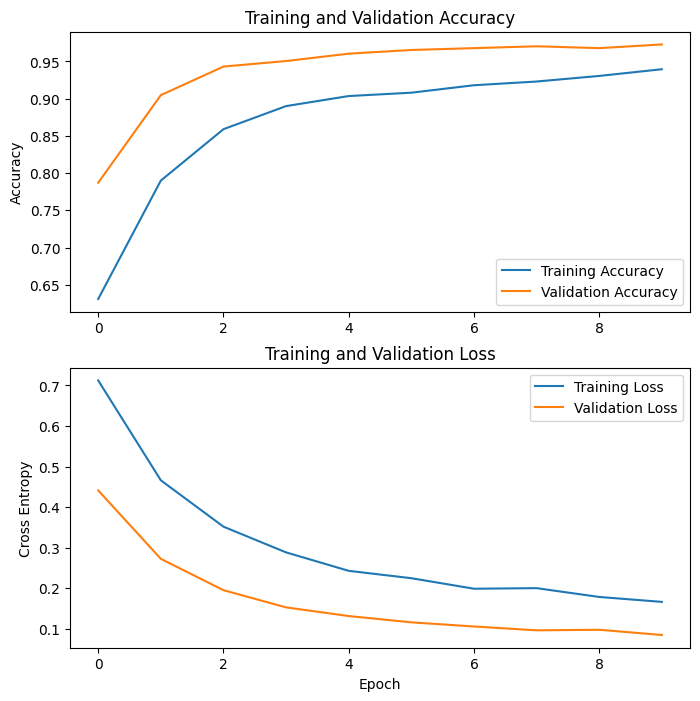

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()


fine tuning of model

In [ ]:

base_model.trainable = True
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])


fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)


Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 518s 8s/step - accuracy: 0.8940 - loss: 0.2703 - val_accuracy: 0.9777 - val_loss: 0.0585
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 494s 8s/step - accuracy: 0.9301 - loss: 0.1722 - val_accuracy: 0.9790 - val_loss: 0.0482
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 513s 8s/step - accuracy: 0.9509 - loss: 0.1336 - val_accuracy: 0.9827 - val_loss: 0.0451
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 549s 8s/step - accuracy: 0.9644 - loss: 0.1032 - val_accuracy: 0.9851 - val_loss: 0.0404
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 488s 8s/step - accuracy: 0.9537 - loss: 0.1091 - val_accuracy: 0.9901 - val_loss: 0.0370
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 499s 8s/step - accuracy: 0.9708 - loss: 0.0875 - val_accuracy: 0.9827 - val_loss: 0.0381
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 488s 8s/step - accuracy: 0.9718 - loss: 0.0692 - val_accuracy: 0.9876 - val_loss: 0.0364
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 501s 8s/step - accuracy: 0.9729 - loss: 0.0686 - val_accuracy: 0.

plotting again after fine tuning

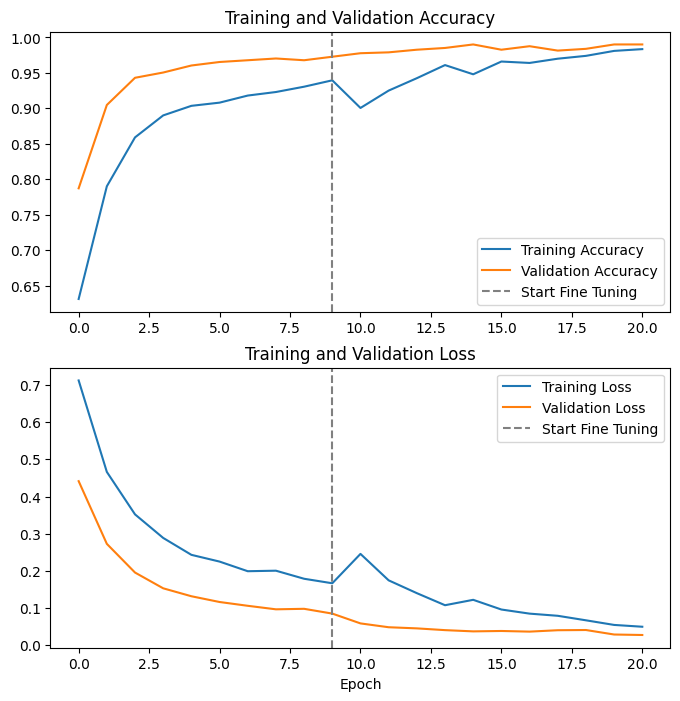

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(x=initial_epochs-1, color='gray', linestyle='--', label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(x=initial_epochs-1, color='gray', linestyle='--', label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()


Evaluation test

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy:', accuracy)


6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.9853 - loss: 0.0415
Test accuracy: 0.9791666865348816


predictions on test samples

Predictions:
 [0 1 0 0 1 1 0 0 1 0 1 1 0 1 0 1 0 1 0 0 0 1 1 0 1 0 1 0 1 0 1 0]
Labels:
 [0 1 0 0 1 1 0 0 1 0 1 1 0 1 0 1 0 1 0 0 0 1 1 0 1 0 1 0 1 0 1 0]


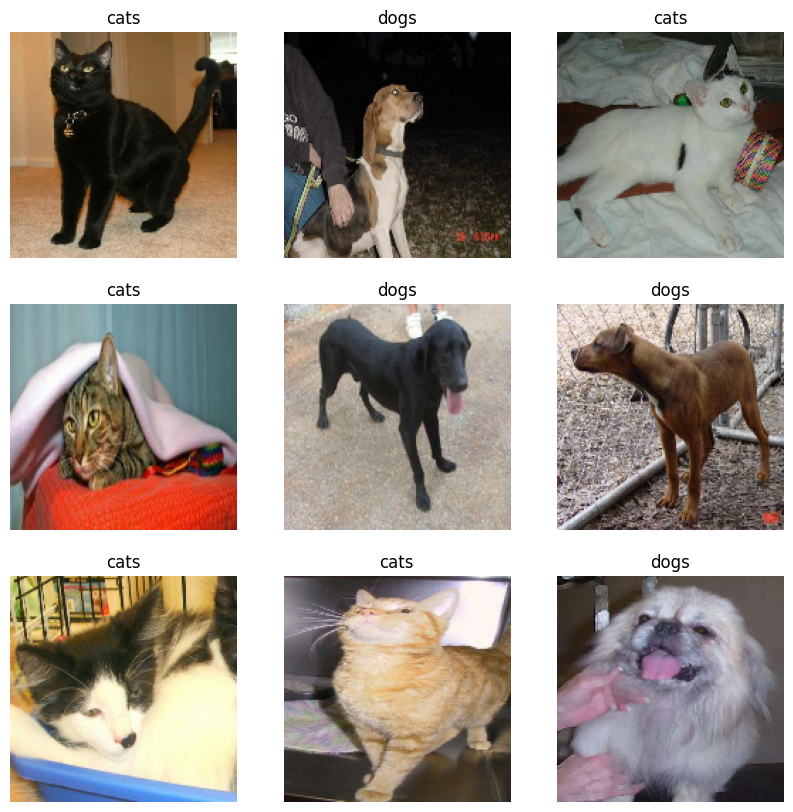

In [ ]:

image_batch, label_batch = test_ds.as_numpy_iterator().next()

predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)


plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")


EfficientNetB0

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

base_model = EfficientNetB0(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
base_model.trainable = False


Data Augmentation

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Compilation

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

Training model

In [ ]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.5290 - loss: 0.7182 - val_accuracy: 0.7030 - val_loss: 0.6127
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.7029 - loss: 0.5841 - val_accuracy: 0.8366 - val_loss: 0.4933
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.8139 - loss: 0.4900 - val_accuracy: 0.8886 - val_loss: 0.4123
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.8553 - loss: 0.4264 - val_accuracy: 0.9319 - val_loss: 0.3496
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.8829 - loss: 0.3769 - val_accuracy: 0.9517 - val_loss: 0.3034
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.9073 - loss: 0.3324 - val_accuracy: 0.9579 - val_loss: 0.2699
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9093 - loss: 0.3115 - val_accuracy: 0.9579 - val_loss: 0.2427
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9105 - loss: 0.2896 - val_accuracy: 0.9592 - va

plotting learning curves

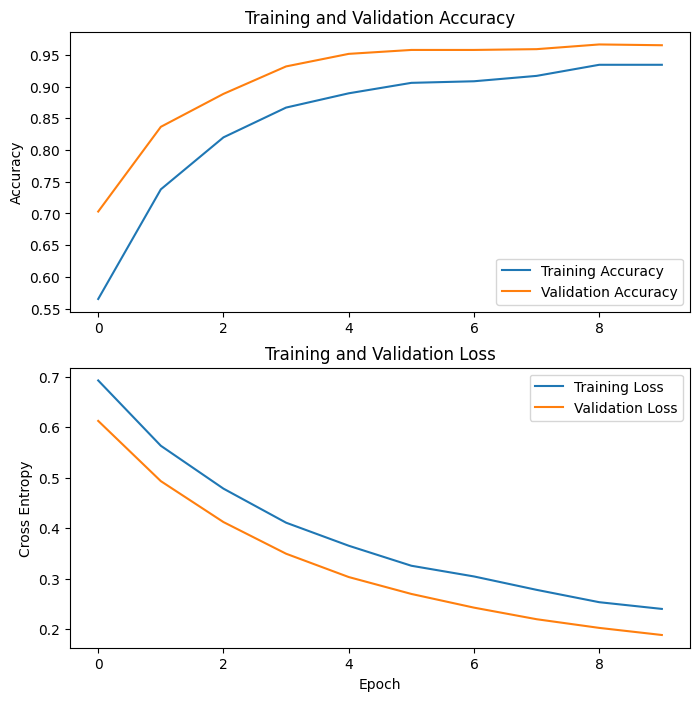

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

Fine tuning of model

In [ ]:

base_model.trainable = True
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])


fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 206s 3s/step - accuracy: 0.7434 - loss: 0.5028 - val_accuracy: 0.9542 - val_loss: 0.1833
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 195s 3s/step - accuracy: 0.8115 - loss: 0.4204 - val_accuracy: 0.9493 - val_loss: 0.1864
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.8571 - loss: 0.3685 - val_accuracy: 0.9455 - val_loss: 0.1825
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.8645 - loss: 0.3458 - val_accuracy: 0.9542 - val_loss: 0.1689
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.9011 - loss: 0.2910 - val_accuracy: 0.9517 - val_loss: 0.1621
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.9056 - loss: 0.2750 - val_accuracy: 0.9592 - val_loss: 0.1465
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 218s 3s/step - accuracy: 0.9057 - loss: 0.2510 - val_accuracy: 0.9616 - val_loss: 0.1356
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.9168 - loss: 0.2290 - val_accuracy: 0.

plotting after fine tuning

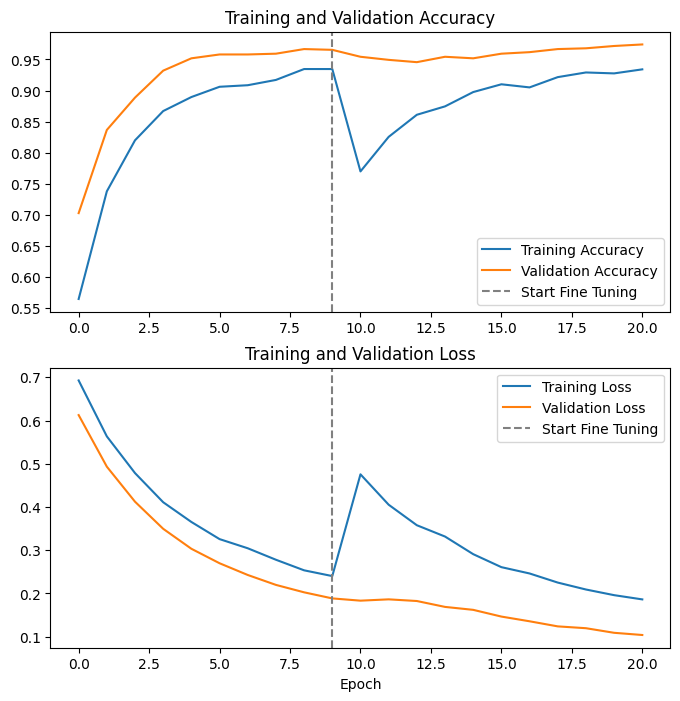

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(x=initial_epochs-1, color='gray', linestyle='--', label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(x=initial_epochs-1, color='gray', linestyle='--', label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()


Evaluation

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy:', accuracy)


6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 939ms/step - accuracy: 0.9961 - loss: 0.0793
Test accuracy: 0.9895833134651184


predicting on test samples

Predictions:
 [0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 0 1 0 1 0 1 0 1 0 0]
Labels:
 [0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 0 1 0 1 0 1 0 1 0 0]


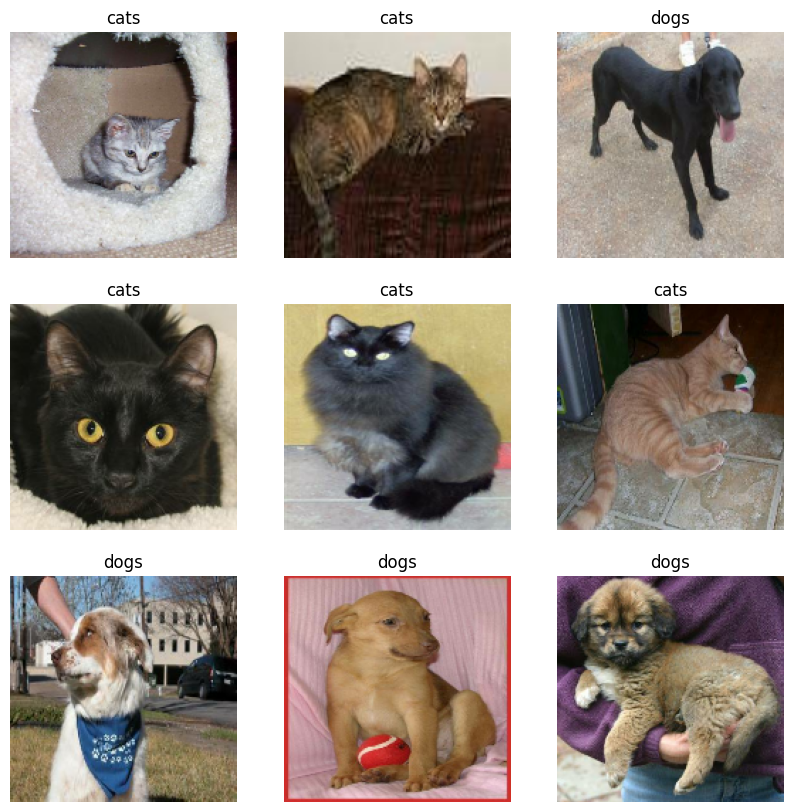

In [ ]:

image_batch, label_batch = test_ds.as_numpy_iterator().next()

predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)


plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

**SUMMARY**

Each model demonstrated solid performance, with EfficientNetB0 yielding the best trade-off between accuracy and training time. ResNet50 showed high accuracy but required more computational resources, while MobileNetV2 trained faster with slightly lower performance.

Transfer learning proved to be an effective approach for binary image classification. It allowed leveraging powerful pre-trained models, significantly reducing training time and computational cost while maintaining high accuracy. Fine-tuning further enhanced the models’ ability to adapt to the specific dataset.